In [1]:
# !pip install -U scikit-learn
# !pip install plotly

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
from torch import nn, optim
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Definimos las siguientes funciones para el preprocesamiento de los datos
#Con la siguiente funciona nos aseguramos que los datos de entrada tengan el formato correcto para el funcionamiento de las redes recurrentes 
def create_sequences(data, lookback=24, forecast_horizon=6):
    xs, ys = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        x = data[i:(i + lookback)]
        y = data[(i + lookback):(i + lookback + forecast_horizon)]
        xs.append(x)
        ys.append(y)

    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


#Con la siguiente funcion analizamos los datos duplicados en el indice del dataframe 
def analyze_duplicate_indices(df):
    # Identificar índices duplicados
    duplicated_indices = df.index[df.index.duplicated(keep=False)]
    
    if duplicated_indices.empty:
        print("No se encontraron índices duplicados.")
        return None

    # Ordenar los duplicados
    duplicates_sorted = df.loc[duplicated_indices].sort_index()

    # Agrupar los duplicados
    grouped_duplicates = duplicates_sorted.groupby(duplicates_sorted.index)

    duplicate_info = []

    for idx, group in grouped_duplicates:
        duplicate_info.append({
            'index': idx,
            'count': len(group),
            'values': group.values.flatten().tolist()
        })

    return duplicate_info

def remove_duplicate_indices(df, method='first'):
    # Analizar duplicados
    duplicate_info = analyze_duplicate_indices(df)
    
    if not duplicate_info:
        print("No hay índices duplicados para eliminar.")
        return df
    
    # Eliminar duplicados
    df_sin_duplicados = df[~df.index.duplicated(keep=method)]
    
    print(f"Se eliminaron {len(df) - len(df_sin_duplicados)} filas con índices duplicados.")
    print(f"Tamaño original del DataFrame: {len(df)}")
    print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")
    
    return df_sin_duplicados

def find_nan_sequences(df, max_consecutive_nans=120, view=False):
    nan_index = df[df.isnull().any(axis=1)].index
    # print(nan_index)
    nan_sequences = []
    
    if len(nan_index) == 0:
        return nan_sequences

    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    for i in range(1, len(nan_index)):
        current_date = nan_index[i]
        
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            # No es consecutivo, guardar la secuencia anterior
            end_date = prev_date
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            if num_nans == 1:
                nan_sequences.append({
                    'type': 'single',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans <= max_consecutive_nans:
                nan_sequences.append({
                    'type': 'consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans > max_consecutive_nans:
                nan_sequences.append({
                    'type': 'long_consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            else:
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            # Iniciar una nueva secuencia
            start_date = current_date
        
        prev_date = current_date
    
    # Manejar la última secuencia
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'date': start_date
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_metrics(y_true, y_pred):
    mse = ((y_true - y_pred) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape

In [3]:
# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
variable = 'CAUDAL_RIO_Aitzu-Urola'
data_river_2 = pd.read_csv('db_21.csv')
data_river_2 = data_river_2.set_index('Fecha')
# Asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')
# Se trabajara sobre la variable de nivel del rio Aitzu-Urola 
imputation_aitsu = data_river_2[[variable]].copy()
date_init = '1999-03-16 17:00'
date_end = '2023-09-30 23:00'
imputation_aitsu = imputation_aitsu[date_init:date_end] 

In [4]:
print(imputation_aitsu.isna().sum())

CAUDAL_RIO_Aitzu-Urola    2087
dtype: int64


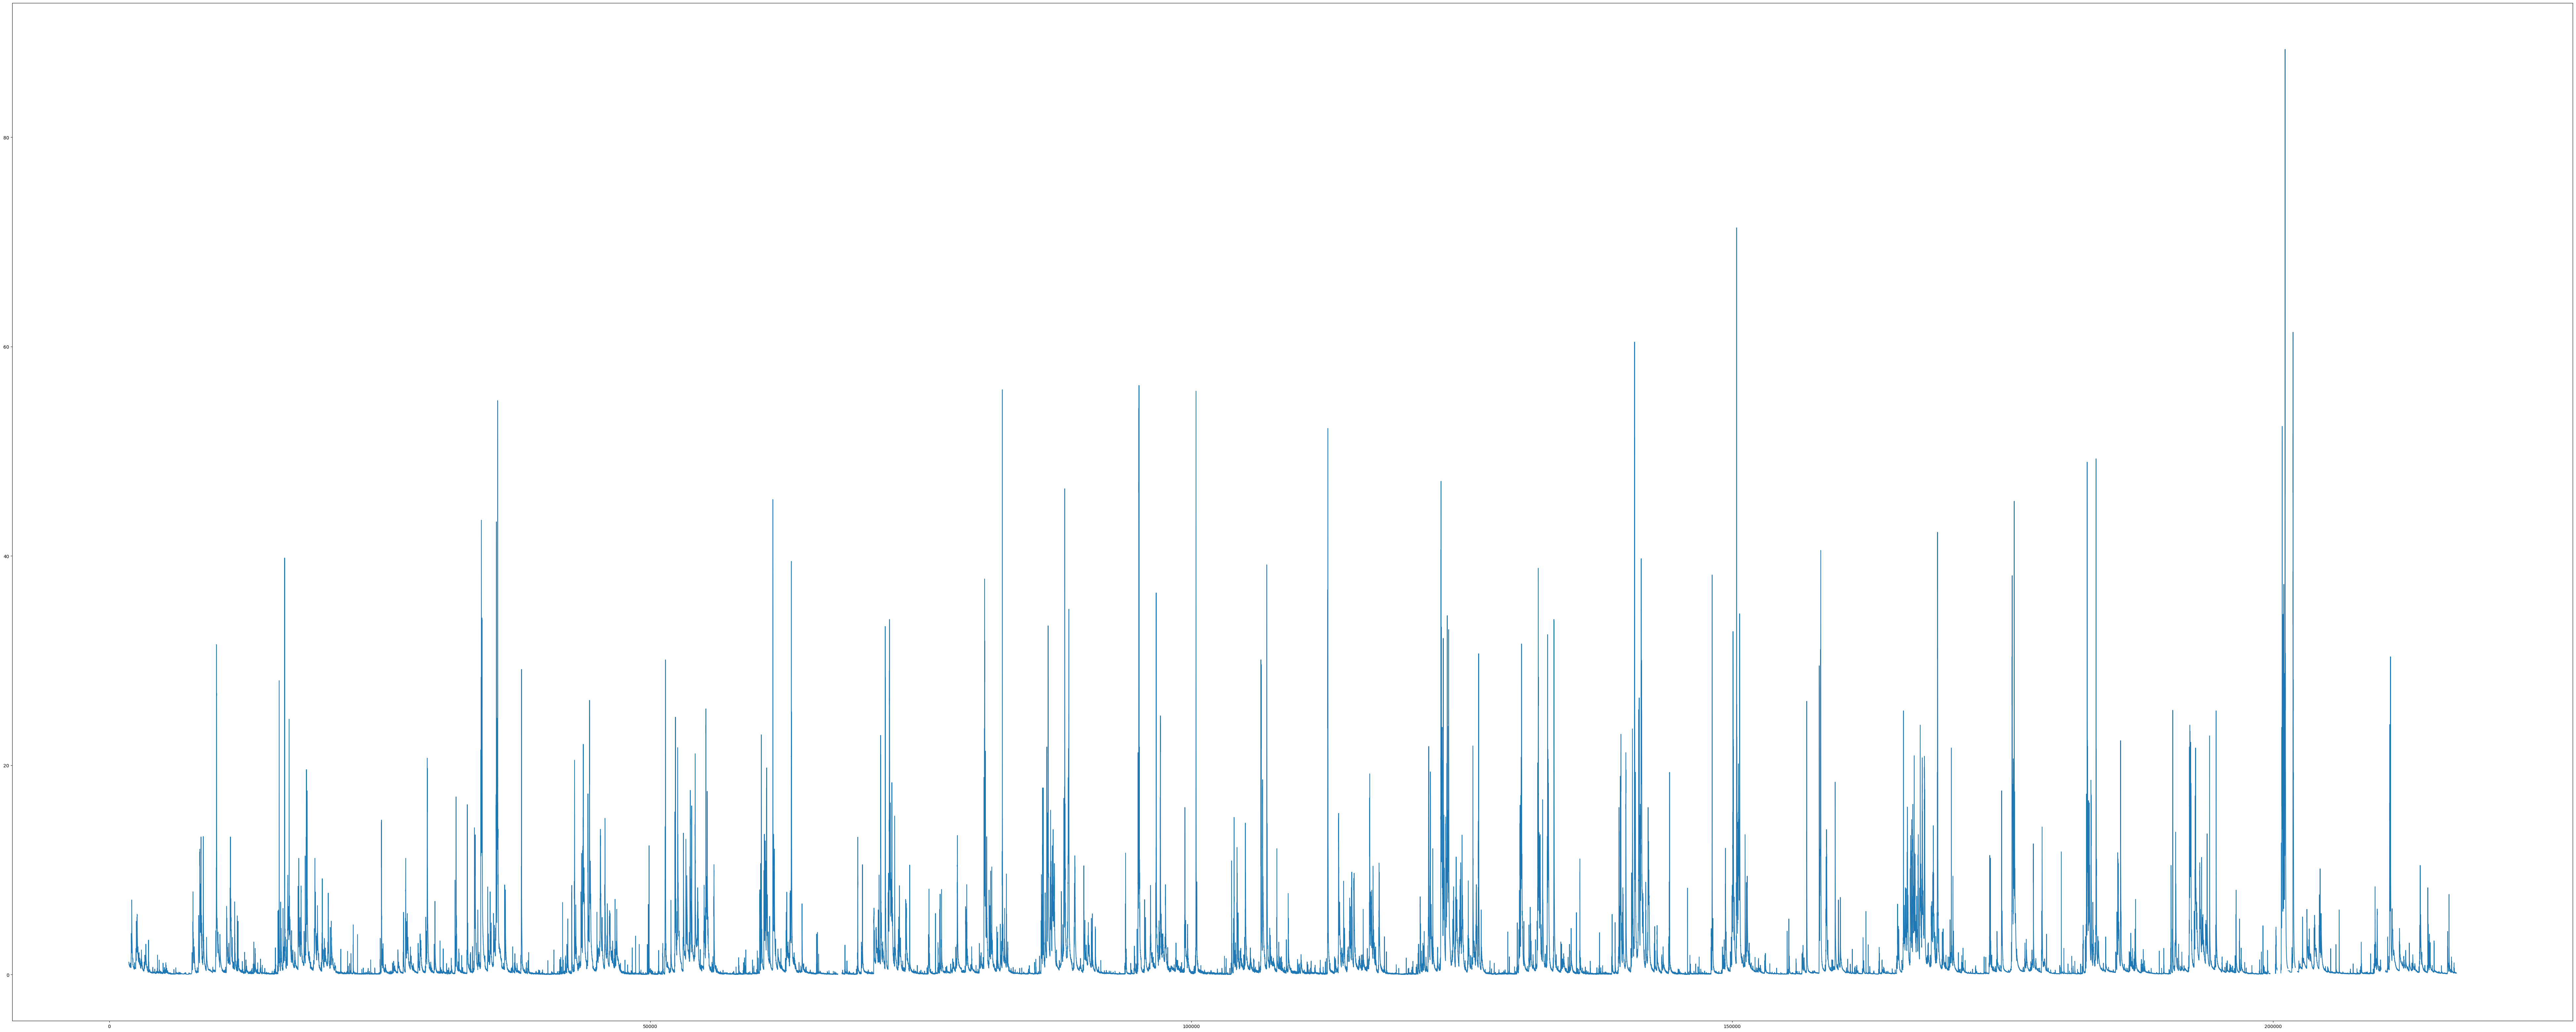

In [5]:
aitzu_image = data_river_2.copy()
plt.figure(figsize=(100, 40))
plt.plot(list(aitzu_image['CAUDAL_RIO_Aitzu-Urola']))
plt.show()

In [6]:
# Usar la función
# duplicate_info = analyze_duplicate_indices(imputation_lluvia_aitsu)

# Usar la función
# imputation_lluvia_aitsu_sin_duplicados = remove_duplicate_indices(imputation_lluvia_aitsu, method='first')

# Uso de la función
nan_sequences = find_nan_sequences(imputation_aitsu, max_consecutive_nans=120, view=True)

# Imprimir resultados
for x in nan_sequences:
    print(x)

Secuencia de NaN mayor a 120 horas: 2022-12-14 13:00:00 a 2022-12-31 23:00:00, 419.0 valores
{'type': 'single', 'start_date': Timestamp('2002-01-08 00:00:00'), 'end_date': Timestamp('2002-01-08 00:00:00'), 'num_nans': 1.0}
{'type': 'consecutive', 'start_date': Timestamp('2003-02-05 12:00:00'), 'end_date': Timestamp('2003-02-05 23:00:00'), 'num_nans': 12.0}
{'type': 'single', 'start_date': Timestamp('2004-11-04 08:00:00'), 'end_date': Timestamp('2004-11-04 08:00:00'), 'num_nans': 1.0}
{'type': 'long_consecutive', 'start_date': Timestamp('2006-09-06 08:00:00'), 'end_date': Timestamp('2006-09-22 14:00:00'), 'num_nans': 391.0}
{'type': 'consecutive', 'start_date': Timestamp('2009-02-03 17:00:00'), 'end_date': Timestamp('2009-02-06 15:00:00'), 'num_nans': 71.0}
{'type': 'consecutive', 'start_date': Timestamp('2009-04-29 11:00:00'), 'end_date': Timestamp('2009-04-29 23:00:00'), 'num_nans': 13.0}
{'type': 'consecutive', 'start_date': Timestamp('2010-08-03 09:00:00'), 'end_date': Timestamp('20

In [7]:
# Seleccionar la secuencia de datos para el entrenamiento
x = 0
# init_train = nan_sequences[0]['end_date'] + pd.Timedelta('1 hour 00:00:00')
end_train = nan_sequences[x]['start_date'] - pd.Timedelta('1 hour 00:00:00')
data_river = imputation_aitsu[:end_train]
print('Fecha de inicio para el entrenamiento ----> ', data_river.index[0])
print('Fecha de fin del entrenamiento ------> ', data_river.index[-1])

total_size = len(data_river)
train_size = int(total_size * 0.70)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size
train = data_river[:train_size]
val = data_river[train_size:train_size + val_size]
test = data_river[train_size + val_size:]

print('Numero de valores para el train:{}, val:{} y test:{}'.format(train.shape, val.shape, test.shape))
print(data_river.isna().sum())

Fecha de inicio para el entrenamiento ---->  1999-03-16 17:00:00
Fecha de fin del entrenamiento ------>  2002-01-07 23:00:00
Numero de valores para el train:(17275, 1), val:(3701, 1) y test:(3703, 1)
CAUDAL_RIO_Aitzu-Urola    0
dtype: int64


In [8]:
# Normalizacion de los datos

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train.values)

MinMaxScaler()

In [9]:
# Transformar los conjuntos
train_scaled = scaler.transform(train.values)
val_scaled = scaler.transform(val.values)
test_scaled = scaler.transform(test.values)

train_scaled = pd.DataFrame(train_scaled, columns=[variable], index=train.index)
val_scaled = pd.DataFrame(val_scaled, columns=[variable], index=val.index)
test_scaled = pd.DataFrame(test_scaled, columns=[variable], index=test.index)

In [10]:
# Crear las secuencias de entrenamiento, validación y test
lookback = 24
forecast_horizon = 6
x_train, y_train = create_sequences(train_scaled.values, lookback, forecast_horizon)
x_val, y_val = create_sequences(val_scaled.values, lookback, forecast_horizon)
x_test, y_test = create_sequences(test_scaled.values, lookback, forecast_horizon)
print('Tamaño de las secuencias:')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

/tmp/ipykernel_247697/2752423071.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


Tamaño de las secuencias:
torch.Size([17246, 24, 1]) torch.Size([17246, 6, 1])
torch.Size([3672, 24, 1]) torch.Size([3672, 6, 1])
torch.Size([3674, 24, 1]) torch.Size([3674, 6, 1])


In [11]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
#         self.linear = nn.Linear(64, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.linear(out)
#         return out

# class ImprovedLSTM(nn.Module):
#     def __init__(self, input_size = 1, hidden_size = 64, num_layers = 2, dropout = 0.2):
#         super(ImprovedLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, 1)
    
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out.unsqueeze(1)
    
class ImprovedLSTM(nn.Module):
       def __init__(self, input_size, hidden_size, num_layers, output_horizon, dropout):
           super(ImprovedLSTM, self).__init__()
           self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)  
           self.fc = nn.Linear(hidden_size, 32)
           self.relu = nn.ReLU()
           self.dropout = nn.Dropout(dropout)
           self.output = nn.Linear(32, output_horizon)
       
       def forward(self, x):
           out, _ = self.lstm(x)
           out = self.fc(out[:, -1, :])
           out = self.relu(out)
           out = self.dropout(out)
           out = self.output(out)
           return out

input_size = 1
hidden_size = 128
num_layers = 2
output_horizon = forecast_horizon
dropout = 0.2

model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_horizon=output_horizon, dropout=dropout)
model = model.to(device)

# class ImprovedModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
#                             num_layers=num_layers, batch_first=True, dropout=dropout)
#         self.linear = nn.Linear(hidden_size, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.linear(out[:, -1, :])  # Toma solo el último paso temporal
#         return out.unsqueeze(1)

# model = ImprovedLSTM(input_size=1, hidden_size=64, num_layers=2, dropout=0.2)
# model = model.to(device)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

weight_decay = 1e-5
lr = 1e-3
batch_size = 128
scheduler_patience = 10
early_stopping_patience = 20
n_epochs = 1000
validation_freq = 1

input_size = 1
hidden_size = 256
num_layers = 3
output_horizon = forecast_horizon
dropout = 0.3

x_train = x_train.to(device).float()    
y_train = y_train.to(device).float()
x_val = x_val.to(device).float()
y_val = y_val.to(device).float()

model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_horizon=output_horizon, dropout=dropout)
model = model.to(device)

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
loss_fn = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=scheduler_patience, threshold=0.00001)

train_losses = []
val_losses = []
best_val_loss = float('inf')
val_rmse = []
val_maes = []
val_mapes = []
learning_rates = []
counter = 0
best_model = None
best_epoch = 0

start_time = time.time()

pred_train = []
pred_val = []
pred_test = []

for epoch in range (n_epochs):

    epoch_start_time = time.time()
    model.train()
    epoch_train_losses = []

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)  # Add an underscore to ignore the hidden state

        loss = loss_fn(y_pred, y_batch.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        epoch_train_losses.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    #Validacion
    if epoch % validation_freq == 0:
        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_val)
            val_loss = loss_fn(y_pred_val, y_val.squeeze())
            val_losses.append(val_loss.item())

            # Corregir la forma de los datos antes de aplicar inverse_transform
            y_true = scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, forecast_horizon))
            y_pred_np = scaler.inverse_transform(y_pred_val.cpu().numpy().reshape(-1, forecast_horizon))
            rmse, mae, mape = calculate_metrics(y_true.flatten(), y_pred_np.flatten())
            val_rmse.append(rmse)
            val_maes.append(mae)
            val_mapes.append(mape)

    scheduler.step(val_loss.item())
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {val_loss.item():.6f}, Val RMSE: {rmse:.6f}, Val MAE: {mae:.6f}, Val MAPE: {mape:.6f}, LR: {current_lr:.8f}, # Epoch total: {n_epochs}')
        
        # Early stopping
    if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            counter = 0
            best_model = model.state_dict()
            best_epoch = epoch
            torch.save(best_model, 'best_model_aitsu.pth')
    else:
            counter += 1
            if counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
    
    epoch_time = time.time() - epoch_start_time

total_time = time.time() - start_time
print(f'\nEntrenamiento completado en {total_time:.2f} segundos')
print(f'Tiempo promedio por época: {total_time/n_epochs:.2f} segundos')
print(f"Best model was saved at epoch {best_epoch} with validation RMSE: {best_val_loss:.4f}")

# Evaluacion en el conjunto de test
# Evaluación en el conjunto de test
model.load_state_dict(torch.load('best_model_aitsu.pth'))
model.eval()
with torch.no_grad():
    y_pred_test = model(x_test.to(device).float())
    y_true_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, forecast_horizon))
    y_pred_test_np = scaler.inverse_transform(y_pred_test.cpu().numpy().reshape(-1, forecast_horizon))
    rmse_test, mae_test, mape_test = calculate_metrics(y_true_test.flatten(), y_pred_test_np.flatten())
    print(f'Test RMSE: {rmse_test:.6f}, Test MAE: {mae_test:.6f}, Test MAPE: {mape_test:.6f}')



Using device: cuda
Epoch 0, Train Loss: 0.003472, Val Loss: 0.000330, Val RMSE: 0.722697, Val MAE: 0.448853, Val MAPE: 1.252685, LR: 0.00100000, # Epoch total: 1000
Epoch 1, Train Loss: 0.001233, Val Loss: 0.000165, Val RMSE: 0.510367, Val MAE: 0.304861, Val MAPE: 1.049090, LR: 0.00100000, # Epoch total: 1000
Epoch 2, Train Loss: 0.001044, Val Loss: 0.000152, Val RMSE: 0.489861, Val MAE: 0.256020, Val MAPE: 0.644448, LR: 0.00100000, # Epoch total: 1000
Epoch 3, Train Loss: 0.000845, Val Loss: 0.000214, Val RMSE: 0.581334, Val MAE: 0.350537, Val MAPE: 0.820398, LR: 0.00100000, # Epoch total: 1000
Epoch 4, Train Loss: 0.000787, Val Loss: 0.000134, Val RMSE: 0.461307, Val MAE: 0.246166, Val MAPE: 0.835643, LR: 0.00100000, # Epoch total: 1000
Epoch 5, Train Loss: 0.000733, Val Loss: 0.000128, Val RMSE: 0.450319, Val MAE: 0.238397, Val MAPE: 0.987145, LR: 0.00100000, # Epoch total: 1000
Epoch 6, Train Loss: 0.000701, Val Loss: 0.000155, Val RMSE: 0.494923, Val MAE: 0.246987, Val MAPE: 0.695

/tmp/ipykernel_247697/4237831012.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_aitsu.pth'))


In [13]:
epochs = list(range(0, n_epochs, 1))  # Asumiendo que guardamos métricas cada 100 épocas
train_losses_plot = train_losses  # Tomamos cada 100º elemento
val_losses_plot = val_losses
val_rmses_plot = val_rmse
learning_rates_plot = learning_rates

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=('Loss', 'Metrics', 'Learning Rate', 'predictions'),
                    vertical_spacing=0.1)

# Añadir pérdidas de entrenamiento y validación
fig.add_trace(go.Scatter(x=epochs, y=train_losses_plot, mode='lines', name='Training Loss',
                         line=dict(color='blue', width=2)),
              row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_losses_plot, mode='lines', name='Validation Loss',
                         line=dict(color='red', width=2)),
              row=1, col=1)

# Añadir RMSE, MAE y MAPE
fig.add_trace(go.Scatter(x=epochs, y=val_rmses_plot, mode='lines', name='RMSE',
                         line=dict(color='green', width=2)),
              row=2, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_maes, mode='lines', name='MAE',
                         line=dict(color='orange', width=2)),
              row=2, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_mapes, mode='lines', name='MAPE',
                         line=dict(color='purple', width=2)),
              row=2, col=1)

# Añadir tasa de aprendizaje
fig.add_trace(go.Scatter(x=epochs, y=learning_rates_plot, mode='lines', name='Learning Rate',
                         line=dict(color='brown', width=2)),
              row=3, col=1)

# # Predicciones de train y val
# fig.add_trace(go.Scatter(x=train.index, y=np.array(pred_train).flatten(), mode='lines', name='Train Predictions',
#                          line=dict(color='blue', width=2)),
#               row=4, col=1)

# fig.add_trace(go.Scatter(x=val.index, y=np.array(pred_val).flatten(), mode='lines', name='Val Predictions',
#                          line=dict(color='red', width=2)),
#               row=4, col=1)


# Actualizar el diseño
fig.update_layout(height=1200, width=1400, title_text="Model Training Metrics")
fig.update_xaxes(title_text="Epoch", row=3, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Metric Value", row=2, col=1)
fig.update_yaxes(title_text="Learning Rate", row=3, col=1)
# fig.update_yaxes(title_text="Predictions", row=4, col=1)

# Mostrar la figura
# fig.show()

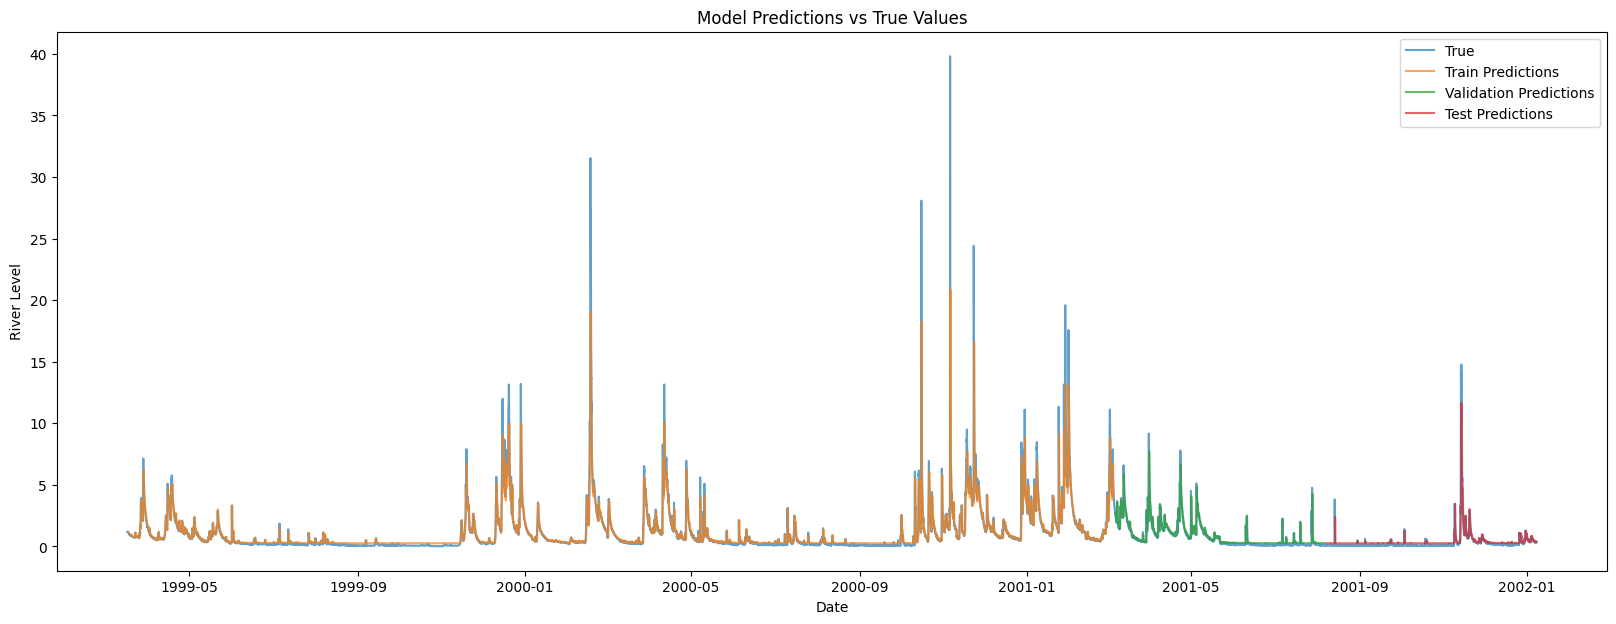

In [14]:
# Preparar los arrays para el plot
data_river_scaled = pd.concat([train_scaled, val_scaled, test_scaled])
data_river_scaled_values = data_river_scaled.values  # Para mayor claridad
total_length = len(data_river_scaled_values)
train_plot = np.ones((total_length, 1)) * np.nan
val_plot = np.ones((total_length, 1)) * np.nan
test_plot = np.ones((total_length, 1)) * np.nan

# Predicciones para el conjunto de entrenamiento
y_pred_train = model(x_train).detach().cpu().numpy()
y_pred_train = y_pred_train.reshape(-1, forecast_horizon)
start_idx = lookback + forecast_horizon - 1
end_idx = start_idx + len(y_pred_train)
train_plot[start_idx:end_idx] = y_pred_train[:, -1].reshape(-1, 1)

# Predicciones para el conjunto de validación
y_pred_val = model(x_val.to(device)).detach().cpu().numpy()
y_pred_val = y_pred_val.reshape(-1, forecast_horizon)
val_start_idx = train_size + lookback + forecast_horizon - 1
val_end_idx = val_start_idx + len(y_pred_val)
val_plot[val_start_idx:val_end_idx] = y_pred_val[:, -1].reshape(-1, 1)

# Predicciones para el conjunto de test
y_pred_test = model(x_test.to(device)).detach().cpu().numpy()
y_pred_test = y_pred_test.reshape(-1, forecast_horizon)
test_start_idx = train_size + val_size + lookback + forecast_horizon - 1
test_end_idx = test_start_idx + len(y_pred_test)
test_plot[test_start_idx:test_end_idx] = y_pred_test[:, -1].reshape(-1, 1)

# Invertir la normalización
train_plot = scaler.inverse_transform(train_plot)
val_plot = scaler.inverse_transform(val_plot)
test_plot = scaler.inverse_transform(test_plot)
true_values = scaler.inverse_transform(data_river_scaled_values)

plt.figure(figsize=(20, 7))
plt.plot(data_river_scaled.index, true_values, label='True', alpha=0.7)
plt.plot(data_river_scaled.index, train_plot, label='Train Predictions', alpha=0.7)
plt.plot(data_river_scaled.index, val_plot, label='Validation Predictions', alpha=0.7)
plt.plot(data_river_scaled.index, test_plot, label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('River Level')
plt.show()



In [ ]:
# !pip install --upgrade nbformat
with torch.no_grad():
    model.eval()
    # Preparar los arrays para el plot
    data_river_scaled = pd.concat([train_scaled, val_scaled, test_scaled])
    total_length = len(data_river_scaled)
    train_plot = np.ones((total_length, 1)) * np.nan
    val_plot = np.ones((total_length, 1)) * np.nan
    test_plot = np.ones((total_length, 1)) * np.nan

    # Predicciones para el conjunto de entrenamiento
    x_train_gpu = x_train.to(device)
    y_pred_train = model(x_train_gpu).cpu().numpy()
    y_pred_train_last = y_pred_train[:, -1]
    train_start_idx = lookback
    train_end_idx = train_start_idx + len(y_pred_train_last)
    train_plot[train_start_idx:train_end_idx] = y_pred_train_last.reshape(-1, 1)

    # Predicciones para el conjunto de validación
    x_val_gpu = x_val.to(device)
    y_pred_val = model(x_val_gpu).cpu().numpy()
    y_pred_val_last = y_pred_val[:, -1]
    val_start_idx = train_size + lookback
    val_end_idx = val_start_idx + len(y_pred_val_last)
    val_plot[val_start_idx:val_end_idx] = y_pred_val_last.reshape(-1, 1)

    # Predicciones para el conjunto de test
    x_test_gpu = x_test.to(device)
    y_pred_test = model(x_test_gpu).cpu().numpy()
    y_pred_test_last = y_pred_test[:, -1]
    test_start_idx = train_size + val_size + lookback
    test_end_idx = test_start_idx + len(y_pred_test_last)
    test_plot[test_start_idx:test_end_idx] = y_pred_test_last.reshape(-1, 1)

    # Invertir la normalización
    train_plot = scaler.inverse_transform(train_plot)
    val_plot = scaler.inverse_transform(val_plot)
    test_plot = scaler.inverse_transform(test_plot)
    true_values = scaler.inverse_transform(data_river_scaled.values)


# Crear el gráfico con Plotly
fig = go.Figure()

# Añadir los datos reales
fig.add_trace(go.Scatter(x=data_river_scaled.index, y=true_values.flatten(),
                         mode='lines', name='Datos Reales', line=dict(color='blue', width=2)))

# Añadir las predicciones de entrenamiento
fig.add_trace(go.Scatter(x=data_river_scaled.index, y=train_plot.flatten(),
                         mode='lines', name='Predicciones Train', line=dict(color='red', width=2)))

# Añadir las predicciones de validación
fig.add_trace(go.Scatter(x=data_river_scaled.index, y=val_plot.flatten(),
                         mode='lines', name='Predicciones Val', line=dict(color='green', width=2)))

# Añadir las predicciones de test
fig.add_trace(go.Scatter(x=data_river_scaled.index, y=test_plot.flatten(),
                         mode='lines', name='Predicciones Test', line=dict(color='purple', width=2)))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Predicciones del Modelo vs Valores Reales',
    xaxis_title='Fecha',
    yaxis_title='Nivel del Río',
    legend_title='Leyenda',
    width=2600,
    height=1000
)

# Añadir las predicciones de cada paso en el horizonte para entrenamiento
for step in range(forecast_horizon):
    offset = step
    train_plot_step = np.ones((total_length, 1)) * np.nan
    start_idx = train_start_idx + offset
    # Calcular la longitud máxima que podemos asignar sin exceder los límites
    max_length = min(len(y_pred_train) - offset, total_length - start_idx)
    if max_length <= 0:
        continue
    train_plot_step[start_idx:start_idx + max_length] = y_pred_train[:max_length, step].reshape(-1, 1)
    train_plot_step = scaler.inverse_transform(train_plot_step)
    # Añadir la predicción al gráfico
    fig.add_trace(go.Scatter(
        x=data_river_scaled.index,
        y=train_plot_step.flatten(),
        mode='lines',
        name=f'Predicción Train Step {step + 1}',
        line=dict(width=1),
        opacity=0.8
    ))


# Añadir las predicciones de cada paso en el horizonte para validación
for step in range(forecast_horizon):
    offset = step
    val_plot_step = np.ones((total_length, 1)) * np.nan
    start_idx = val_start_idx + offset
    # Calcular la longitud máxima que podemos asignar sin exceder los límites
    max_length = min(len(y_pred_val) - offset, total_length - start_idx)
    if max_length <= 0:
        continue
    val_plot_step[start_idx:start_idx + max_length] = y_pred_val[:max_length, step].reshape(-1, 1)
    val_plot_step = scaler.inverse_transform(val_plot_step)
    # Añadir la predicción al gráfico
    fig.add_trace(go.Scatter(
        x=data_river_scaled.index,
        y=val_plot_step.flatten(),
        mode='lines',
        name=f'Predicción Val Step {step + 1}',
        line=dict(width=1, dash='dash'),
        opacity=0.85
    ))

# Añadir las predicciones de cada paso en el horizonte para test
for step in range(forecast_horizon):
    offset = step
    test_plot_step = np.ones((total_length, 1)) * np.nan
    start_idx = test_start_idx + offset
    # Calcular la longitud máxima que podemos asignar sin exceder los límites
    max_length = min(len(y_pred_test) - offset, total_length - start_idx)
    if max_length <= 0:
        continue
    test_plot_step[start_idx:start_idx + max_length] = y_pred_test[:max_length, step].reshape(-1, 1)
    test_plot_step = scaler.inverse_transform(test_plot_step)
    # Añadir la predicción al gráfico
    fig.add_trace(go.Scatter(
        x=data_river_scaled.index,
        y=test_plot_step.flatten(),
        mode='lines',
        name=f'Predicción Test Step {step + 1}',
        line=dict(width=1, dash='dot'),
        opacity=0.9
    ))

# Mostrar el gráfico
fig.show()


In [17]:
def predict_future(model, last_known_sequence, data_miss):
    model.eval()
    future_predictions = []
    current_sequence = last_known_sequence.clone().to(device)

    for _ in range(data_miss):
        with torch.no_grad():
            prediction = model(current_sequence.float())
            future_predictions.append(prediction[0, -1].item())
            current_sequence = torch.cat((current_sequence[:, 1:, :], prediction[:, -1:, :]), dim=1)

    return future_predictions

In [ ]:
def predict_future_autoregressive(model, last_known_sequence, data_miss, scaler, original_data, device):
    model.eval()
    future_predictions = []
    # Convertir la secuencia conocida en un tensor de PyTorch
    current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    for _ in range(data_miss):
        with torch.no_grad():
            # Generar la predicción
            prediction = model(current_sequence.float())
            prediction = prediction.unsqueeze(-1)  # Aseguramos que prediction sea 3D

            # Extraer la primera predicción y añadirla a las predicciones futuras
            future_predictions.append(prediction[0, -1, 0].item())

            # Actualizar la secuencia actual con la predicción generada
            current_sequence = torch.cat((current_sequence[:, 1:, :], prediction[:, -1:, :]), dim=1)

    # Invertir la normalización de las predicciones
    future_predictions_scaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Obtener la fecha más reciente de los datos conocidos
    last_date = original_data.index[-1]
    
    # Crear las fechas correspondientes para las predicciones
    future_dates = pd.date_range(last_date + pd.Timedelta('1 hour'), periods=len(future_predictions_scaled), freq='H')

    # Crear un DataFrame con las fechas y las predicciones escaladas
    future_predictions_df = pd.DataFrame(future_predictions_scaled, columns=['Prediction'], index=future_dates)

    # Actualizar el DataFrame original con la primera predicción
    print(original_data.size)
    original_data.loc[future_dates[0]] = future_predictions_scaled[0, 0]
    print('='*50)
    print(original_data.size)
    
    return future_predictions_df, original_data

# Ejemplo de uso
num_future_steps = int(nan_sequences[x].get('num_nans'))
print(num_future_steps)  # La cantidad de pasos que deseas predecir
last_known_sequence = test_scaled[-lookback:].values
print(data_river.size)
future_predictions_df, updated_data = predict_future_autoregressive(model, last_known_sequence, num_future_steps, scaler, imputation_aitsu, device)


# Imprimir los resultados
print("Predicciones futuras:")
print(future_predictions_df)

print("Datos originales actualizados con la primera predicción:")
print(updated_data.tail(20))


1
24679
215143
215144
Predicciones futuras:
            Prediction
2023-10-01    0.330478
Datos originales actualizados con la primera predicción:
                     CAUDAL_RIO_Aitzu-Urola
Fecha                                      
2023-09-30 05:00:00                0.124900
2023-09-30 06:00:00                0.124900
2023-09-30 07:00:00                0.124900
2023-09-30 08:00:00                0.127700
2023-09-30 09:00:00                0.148900
2023-09-30 10:00:00                0.161900
2023-09-30 11:00:00                0.175500
2023-09-30 12:00:00                0.175500
2023-09-30 13:00:00                0.168600
2023-09-30 14:00:00                0.168600
2023-09-30 15:00:00                0.168600
2023-09-30 16:00:00                0.168600
2023-09-30 17:00:00                0.161900
2023-09-30 18:00:00                0.155300
2023-09-30 19:00:00                0.155300
2023-09-30 20:00:00                0.155300
2023-09-30 21:00:00                0.148900
2023-09-30 22:00:

In [ ]:
nan_sequences = find_nan_sequences(data_river_2, max_consecutive_nans=120, view=True)
nan_sequences

Secuencia de NaN mayor a 120 horas: 2023-09-18 10:00:00 a 2024-12-31 23:00:00, 11294.0 valores


[{'type': 'long_consecutive',
  'start_date': Timestamp('1999-01-01 00:00:00'),
  'end_date': Timestamp('2018-10-06 18:00:00'),
  'num_nans': 173251.0},
 {'type': 'consecutive',
  'start_date': Timestamp('2018-10-06 20:00:00'),
  'end_date': Timestamp('2018-10-07 02:00:00'),
  'num_nans': 7.0},
 {'type': 'single',
  'start_date': Timestamp('2018-10-07 06:00:00'),
  'end_date': Timestamp('2018-10-07 06:00:00'),
  'num_nans': 1.0},
 {'type': 'consecutive',
  'start_date': Timestamp('2018-10-07 09:00:00'),
  'end_date': Timestamp('2018-10-07 14:00:00'),
  'num_nans': 6.0},
 {'type': 'consecutive',
  'start_date': Timestamp('2018-10-07 17:00:00'),
  'end_date': Timestamp('2018-10-07 18:00:00'),
  'num_nans': 2.0},
 {'type': 'single',
  'start_date': Timestamp('2018-10-08 00:00:00'),
  'end_date': Timestamp('2018-10-08 00:00:00'),
  'num_nans': 1.0},
 {'type': 'single',
  'start_date': Timestamp('2018-10-08 02:00:00'),
  'end_date': Timestamp('2018-10-08 02:00:00'),
  'num_nans': 1.0},
 {'t

In [ ]:
#Modelo
class ImprovedLSTM(nn.Module):
       def __init__(self, input_size, hidden_size, num_layers, output_horizon, dropout):
           super(ImprovedLSTM, self).__init__()
           self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)  
           self.fc = nn.Linear(hidden_size, 32)
           self.relu = nn.ReLU()
           self.dropout = nn.Dropout(dropout)
           self.output = nn.Linear(32, output_horizon)
       
       def forward(self, x):
           out, _ = self.lstm(x)
           out = self.fc(out[:, -1, :])
           out = self.relu(out)
           out = self.dropout(out)
           out = self.output(out)
           return out

input_size = 1
hidden_size = 128
num_layers = 2
dropout = 0.3
output_horizon = 6

model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_horizon=output_horizon, dropout=dropout)
model = model.to(device) 

# Función principal que realiza el proceso de predicción para completar los valores faltantes
def fill_missing_values_with_lstm(data, nan_sequences, lookback, forecast_horizon, model, device, num_epochs=5000):
    for x in range(len(nan_sequences)):
        # Obtener la ventana de datos hasta el primer valor faltante
        end_train = nan_sequences[x]['start_date'] - pd.Timedelta('1 hour 00:00:00')
        data_river = data[:end_train]
        print(f'Inicio del entrenamiento: {data_river.index[0]}, Fin del entrenamiento: {data_river.index[-1]}')

        # Dividir los datos en train, val y test
        total_size = len(data_river)
        train_size = int(total_size * 0.70)
        val_size = int(total_size * 0.15)
        test_size = total_size - train_size - val_size
        train = data_river[:train_size]
        val = data_river[train_size:train_size + val_size]
        test = data_river[train_size + val_size:]

        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(train.values)

        # Normalizar los datos
        scaler.fit(train.values)
        train_scaled = scaler.transform(train.values)
        val_scaled = scaler.transform(val.values)
        test_scaled = scaler.transform(test.values)

        # Crear las secuencias de entrenamiento, validación y test
        x_train, y_train = create_sequences(train_scaled, lookback, forecast_horizon)
        x_val, y_val = create_sequences(val_scaled, lookback, forecast_horizon)
        x_test, y_test = create_sequences(test_scaled, lookback, forecast_horizon)

        # Convertir los datos a tensores y moverlos a la GPU si es posible
        x_train, y_train = x_train.to(device), y_train.to(device)
        x_val, y_val = x_val.to(device), y_val.to(device)

        # Entrenar el modelo
        model = train_lstm_model(model, x_train, y_train, x_val, y_val, num_epochs, device)

        # Obtener la última secuencia de datos conocida (última ventana del test set)
        last_known_sequence = torch.tensor(test_scaled[-lookback:], dtype=torch.float32).unsqueeze(0).to(device)

        # Número de valores faltantes consecutivos
        num_future_steps = int(nan_sequences[x].get('num_nans'))
        print(f'Número de pasos futuros a predecir: {num_future_steps}')

        # Realizar predicción autoregresiva
        future_predictions_df, data = predict_future_autoregressive(model, last_known_sequence, num_future_steps, scaler, data, device)

        print(f'Predicciones para el hueco {x+1}:')
        print(future_predictions_df)

    return data, scaler

# Función para entrenar el modelo LSTM
def train_lstm_model(model, x_train, y_train, x_val, y_val, num_epochs, device):
    print(f"Entrenando el modelo durante {num_epochs} épocas...")
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(x_train)
        loss = loss_fn(y_pred_train, y_train.squeeze())
        loss.backward()
        optimizer.step()

        # Validación
        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_val)
            val_loss = loss_fn(y_pred_val, y_val.squeeze())
            if val_loss < best_val_loss:
                best_val_loss = val_loss.item()
                best_model = model.state_dict()
                torch.save(best_model, 'best_lstm_model.pth')

        scheduler.step(val_loss)

    # Cargar el mejor modelo
    print(f"Mejor modelo guardado con pérdida de validación: {best_val_loss:.6f}")
    model.load_state_dict(torch.load('best_lstm_model.pth'))
    return model


def predict_future_autoregressive(model, last_known_sequence, data_miss, scaler, original_data, device):
    print('Predicting future values...')
    model.eval()
    future_predictions = []
    
    # Convertir la secuencia conocida en un tensor de PyTorch
    current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    # Revisar que current_sequence tenga las dimensiones correctas (batch_size, sequence_length, input_size)
    if current_sequence.dim() == 4:
        current_sequence = current_sequence.squeeze(0)  # Eliminar la dimensión extra si es 4D

    for _ in range(data_miss):
        with torch.no_grad():
            # Generar la predicción
            prediction = model(current_sequence.float())
            
            # Asegurarse de que prediction sea 3D antes de la concatenación
            if prediction.dim() == 2:
                prediction = prediction.unsqueeze(-1)  # Convertir a 3D (batch_size, output_horizon, input_size)

            # Extraer la primera predicción y añadirla a las predicciones futuras
            future_predictions.append(prediction[0, -1, 0].item())

            # Actualizar la secuencia actual con la predicción generada
            current_sequence = torch.cat((current_sequence[:, 1:, :], prediction[:, -1:, :]), dim=1)

    # Invertir la normalización de las predicciones
    future_predictions_scaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Obtener la fecha más reciente de los datos conocidos
    last_date = original_data.index[-1]
    
    # Crear las fechas correspondientes para las predicciones
    future_dates = pd.date_range(last_date + pd.Timedelta('1 hour'), periods=len(future_predictions_scaled), freq='H')

    # Crear un DataFrame con las fechas y las predicciones escaladas
    future_predictions_df = pd.DataFrame(future_predictions_scaled, columns=['Prediction'], index=future_dates)

    # Actualizar el DataFrame original con la primera predicción
    original_data.loc[future_dates[0]] = future_predictions_scaled[0, 0]
    
    return future_predictions_df, original_data

# Ejemplo de uso
nan_sequences = find_nan_sequences(imputation_aitsu, max_consecutive_nans=120, view=True)
imputation_aitsu_filled, scaler = fill_missing_values_with_lstm(imputation_aitsu, nan_sequences, lookback=24, forecast_horizon=6, model=model, device=device)

Secuencia de NaN mayor a 120 horas: 2022-12-14 13:00:00 a 2022-12-31 23:00:00, 419.0 valores
Inicio del entrenamiento: 1999-03-16 17:00:00, Fin del entrenamiento: 2002-01-07 23:00:00


/tmp/ipykernel_156418/2752423071.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000

/tmp/ipykernel_156418/508047181.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence = torch.tensor(last_known_sequence, dtype=torch.float32).unsqueeze(0).to(device)


Entrenando el modelo durante 5000 épocas...
Epoch 1/5000


OutOfMemoryError: CUDA out of memory. Tried to allocate 17.47 GiB. GPU 

In [7]:
# %%
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
from torch import nn, optim
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# %%
# Definimos las funciones necesarias para el preprocesamiento y análisis de los datos
def create_sequences(data, lookback=24, forecast_horizon=6):
    xs, ys = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        x = data[i:(i + lookback)]
        y = data[(i + lookback):(i + lookback + forecast_horizon)]
        xs.append(x)
        ys.append(y)

    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

def analyze_duplicate_indices(df):
    duplicated_indices = df.index[df.index.duplicated(keep=False)]
    
    if duplicated_indices.empty:
        print("No se encontraron índices duplicados.")
        return None

    duplicates_sorted = df.loc[duplicated_indices].sort_index()

    grouped_duplicates = duplicates_sorted.groupby(duplicates_sorted.index)

    duplicate_info = []

    for idx, group in grouped_duplicates:
        duplicate_info.append({
            'index': idx,
            'count': len(group),
            'values': group.values.flatten().tolist()
        })

    return duplicate_info

def remove_duplicate_indices(df, method='first'):
    duplicate_info = analyze_duplicate_indices(df)
    
    if not duplicate_info:
        print("No hay índices duplicados para eliminar.")
        return df
    
    df_sin_duplicados = df[~df.index.duplicated(keep=method)]
    
    print(f"Se eliminaron {len(df) - len(df_sin_duplicados)} filas con índices duplicados.")
    print(f"Tamaño original del DataFrame: {len(df)}")
    print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")
    
    return df_sin_duplicados

def find_nan_sequences(df, max_consecutive_nans=500, view=False):
    nan_index = df[df.isnull().any(axis=1)].index
    nan_sequences = []
    
    if len(nan_index) == 0:
        return nan_sequences

    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    for i in range(1, len(nan_index)):
        current_date = nan_index[i]
        
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            end_date = prev_date
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            if num_nans == 1:
                nan_sequences.append({
                    'type': 'single',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans <= max_consecutive_nans:
                nan_sequences.append({
                    'type': 'consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans > max_consecutive_nans:
                nan_sequences.append({
                    'type': 'long_consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            else:
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            start_date = current_date
        
        prev_date = current_date
    
    # Manejar la última secuencia
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_metrics(y_true, y_pred):
    mse = ((y_true - y_pred) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape



# %%
# Definir el modelo LSTM mejorado
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_horizon, dropout):
        super(ImprovedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)  
        self.fc = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(32, output_horizon)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.output(out)
        return out


# %%
# Función para entrenar el modelo con los datos disponibles
def train_model(data_river, lookback=24, forecast_horizon=6):
    print('inicio train')
    total_size = len(data_river)
    train_size = int(total_size * 0.70)
    val_size = int(total_size * 0.15)
    test_size = total_size - train_size - val_size
    train = data_river[:train_size]
    val = data_river[train_size:train_size + val_size]
    test = data_river[train_size + val_size:]

    print('normalize')
    # Normalización
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train.values)

    print('transform')
    # Transformar los conjuntos
    train_scaled = scaler.transform(train.values)
    val_scaled = scaler.transform(val.values)
    test_scaled = scaler.transform(test.values)

    print('secuencias')
    # Crear secuencias
    x_train, y_train = create_sequences(train_scaled, lookback, forecast_horizon)
    x_val, y_val = create_sequences(val_scaled, lookback, forecast_horizon)
    x_test, y_test = create_sequences(test_scaled, lookback, forecast_horizon)
    print(f"Longitud de x_train: {len(x_train)}, Longitud de x_val: {len(x_val)}, Longitud de x_test: {len(x_test)}")

    print('tensores')
    # Convertir a tensores
    print(device)
    print(x_train)
    x_train = x_train.to(device).float()    
    y_train = y_train.to(device).float()
    x_val = x_val.to(device).float()
    y_val = y_val.to(device).float()

    print('iniciando el modelo')
    # Inicializar el modelo
    input_size = 1
    hidden_size = 256
    num_layers = 3
    dropout = 0.3

    model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_horizon=forecast_horizon, dropout=dropout)
    model = model.to(device)

    print('set parameters')
    # Parámetros de entrenamiento
    weight_decay = 1e-5
    lr = 1e-3
    batch_size = 64
    scheduler_patience = 10
    early_stopping_patience = 20
    n_epochs = 1000
    validation_freq = 1

    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=scheduler_patience, threshold=0.00001)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    val_rmse = []
    val_maes = []
    val_mapes = []
    learning_rates = []
    counter = 0
    best_model = None
    best_epoch = 0

    start_time = time.time()
    print('star training')
    for epoch in range (n_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_train_losses = []

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_train_losses.append(loss.item())
        
        epoch_train_loss = np.mean(epoch_train_losses)
        train_losses.append(epoch_train_loss)
        print('Validacion')
        # Validación
        if epoch % validation_freq == 0:
            model.eval()
            with torch.no_grad():
                y_pred_val = model(x_val)
                val_loss = loss_fn(y_pred_val, y_val.squeeze())
                val_losses.append(val_loss.item())

                y_true = scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, forecast_horizon))
                y_pred_np = scaler.inverse_transform(y_pred_val.cpu().numpy().reshape(-1, forecast_horizon))
                rmse, mae, mape = calculate_metrics(y_true.flatten(), y_pred_np.flatten())
                val_rmse.append(rmse)
                val_maes.append(mae)
                val_mapes.append(mape)

        scheduler.step(val_loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            counter = 0
            best_model = model.state_dict()
            best_epoch = epoch
            torch.save(best_model, 'best_model_temp.pth')
        else:
            counter += 1
            if counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
        
        epoch_time = time.time() - epoch_start_time

    total_time = time.time() - start_time
    print(f'\nEntrenamiento completado en {total_time:.2f} segundos')
    print(f'Tiempo promedio por época: {total_time/n_epochs:.2f} segundos')
    print(f"Best model was saved at epoch {best_epoch} with validation RMSE: {best_val_loss:.4f}")

    # Cargar el mejor modelo
    model.load_state_dict(torch.load('best_model_temp.pth'))

    # save_images_train_model(epoch, train_losses, val_losses, val_rmse, val_maes, val_mapes, learning_rates)

    return model, scaler

# %%
# Función para predecir los valores faltantes
def predict_missing_values(model, scaler, imputation_aitsu, start_date, end_date, lookback=24, forecast_horizon=6):
    data_before = imputation_aitsu[:start_date - pd.Timedelta('1 hour')]
    input_data = data_before[-lookback:].values
    input_scaled = scaler.transform(input_data)

    missing_dates = pd.date_range(start=start_date, end=end_date, freq='H')
    predicted_values = []

    x_input = torch.tensor(input_scaled.reshape(1, lookback, 1), dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        while len(predicted_values) < len(missing_dates):
            y_pred = model(x_input).cpu().numpy()  # y_pred tiene forma (1, forecast_horizon)
            y_pred_inv = scaler.inverse_transform(y_pred)  # Desescalar para obtener los valores originales
            predicted_values.extend(y_pred_inv.flatten())

            # Actualizar x_input con los nuevos valores predichos escalados
            last_values = np.concatenate((x_input.cpu().numpy().flatten()[forecast_horizon:], y_pred.flatten()))
            x_input = torch.tensor(last_values[-lookback:].reshape(1, lookback, 1), dtype=torch.float32).to(device)

    predicted_values = predicted_values[:len(missing_dates)]

    df_pred = pd.DataFrame(data=predicted_values, index=missing_dates, columns=[variable])

    return df_pred

# %%
# Cargar los datos y preprocesar
variable = 'LLUVIA_Aitzu-Urola'
data_river_2 = pd.read_csv('db_21.csv')
data_river_2 = data_river_2.set_index('Fecha')
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')

imputation_aitsu = data_river_2[[variable]].copy()
date_init = '1999-03-16 17:00'
date_end = '2023-09-30 23:00'
imputation_aitsu = imputation_aitsu[date_init:date_end] 

# %%
# Encontrar las secuencias de valores faltantes
nan_sequences = find_nan_sequences(imputation_aitsu, max_consecutive_nans=120, view=True)

# %%
# Proceso iterativo para completar los valores faltantes
lookback = 24
forecast_horizon = 6

for seq in nan_sequences:
    if seq['type'] == 'long consecutive':
        print(f"Secuencia de valores faltantes muy larga: {seq['start_date']} a {seq['end_date']}, {int(seq['num_nans'])} valores")
    else:
        start_date = seq['start_date']
        end_date = seq['end_date']
        num_nans = seq['num_nans']

        # Obtener los datos hasta la secuencia faltante
        data_river = imputation_aitsu[:start_date - pd.Timedelta('1 hour')]

        # Verificar si hay suficientes datos para entrenar
        if len(data_river) < lookback + forecast_horizon:
            print(f"No hay suficientes datos para entrenar antes de {start_date}")
            continue

        print(f"Entrenando modelo para predecir valores faltantes desde {start_date} hasta {end_date} ({int(num_nans)} valores faltantes)")

        # Entrenar el modelo
        model, scaler = train_model(data_river, lookback, forecast_horizon)

        # Predecir los valores faltantes
        df_pred = predict_missing_values(model, scaler, imputation_aitsu, start_date, end_date, lookback=lookback, forecast_horizon=forecast_horizon)

        # Actualizar el DataFrame principal con los valores predichos
        imputation_aitsu.update(df_pred)

# %%
# Verificar si quedan valores faltantes
remaining_nans = imputation_aitsu.isna().sum()
print(f"Valores faltantes restantes: {remaining_nans}")

# %%
# Guardar el DataFrame con los valores completados
imputation_aitsu.to_csv('imputation_caudal'+variable+'_completed.csv')

# Opcional: graficar los datos originales y los datos completados
plt.figure(figsize=(20, 7))
plt.plot(imputation_aitsu.index, imputation_aitsu[variable], label='Datos con imputación', alpha=0.7)
plt.legend()
plt.title('Datos con valores imputados')
plt.xlabel('Fecha')
plt.ylabel('Nivel del Río')
plt.show()


No hay suficientes datos para entrenar antes de 1999-03-16 17:00:00
Entrenando modelo para predecir valores faltantes desde 2000-05-25 08:00:00 hasta 2000-05-25 08:00:00 (1 valores faltantes)
inicio train
normalize
transform
secuencias


/home/alumno/anaconda3/envs/ia4flood_pytorch/lib/python3.9/site-packages/sklearn/utils/_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/alumno/anaconda3/envs/ia4flood_pytorch/lib/python3.9/site-packages/sklearn/utils/_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Longitud de x_train: 7289, Longitud de x_val: 1539, Longitud de x_test: 1540
tensores
cuda
tensor([[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]])


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
urola_Data = pd.read_csv("imputation_CAUDAL_RIO_Ibaieder_completed.csv")
urola_Data = urola_Data.set_index('Fecha')
urola_Data.index = pd.to_datetime(urola_Data.index, format='%Y-%m-%d %H:%M:%S')
urola_Data

,CAUDAL_RIO_Ibaieder
Fecha,
1999-03-16 17:00:00,1.1124
1999-03-16 18:00:00,1.1124
1999-03-16 19:00:00,1.1124
1999-03-16 20:00:00,1.1124
1999-03-16 21:00:00,1.1124
...,...
2023-09-30 19:00:00,0.2445
2023-09-30 20:00:00,0.2445
2023-09-30 21:00:00,0.2487


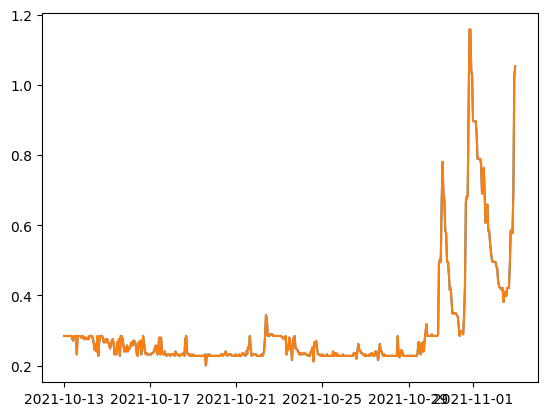

In [7]:
init = "2021-10-13"
end = "2021-11-02"
plt.plot(urola_Data[init:end][variable])
plt.plot(data_river_2[init:end][variable])

In [8]:
# print(urola_Data.isna().sum())
nan_sequences1 = find_nan_sequences(urola_Data, max_consecutive_nans=120, view=True)

In [12]:
import torch

def predict_date_range(model_path, scaler, imputation_aitsu, start_date, end_date, lookback=100, forecast_horizon=6):
    class ImprovedLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_horizon, dropout):
            super(ImprovedLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 32)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)
            self.output = nn.Linear(32, output_horizon)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])
            out = self.relu(out)
            out = self.dropout(out)
            out = self.output(out)
            return out

    # Convert start_date and end_date to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Load the saved model
    model = ImprovedLSTM(input_size=1, hidden_size=256, num_layers=3, output_horizon=forecast_horizon, dropout=0.2)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Prepare data up to the prediction start date
    data_before = imputation_aitsu[:start_date - pd.Timedelta('1 hour')]
    input_data = data_before[-lookback:].values
    input_scaled = scaler.transform(input_data)

    # Set up the input tensor for prediction
    missing_dates = pd.date_range(start=start_date, end=end_date, freq='H')
    predicted_values = []
    x_input = torch.tensor(input_scaled.reshape(1, lookback, 1), dtype=torch.float32).to(device)

    # Make predictions
    with torch.no_grad():
        while len(predicted_values) < len(missing_dates):
            y_pred = model(x_input).cpu().numpy()
            y_pred_inv = scaler.inverse_transform(y_pred)
            predicted_values.extend(y_pred_inv.flatten())

            # Update input for the next prediction
            last_values = np.concatenate((x_input.cpu().numpy().flatten()[forecast_horizon:], y_pred.flatten()))
            x_input = torch.tensor(last_values[-lookback:].reshape(1, lookback, 1), dtype=torch.float32).to(device)

    predicted_values = predicted_values[:len(missing_dates)]
    df_pred = pd.DataFrame(data=predicted_values, index=missing_dates, columns=[variable])

    return df_pred


In [13]:
start_date = '2021-10-13'
end_date = '2021-11-02'
df_pred = predict_date_range('best_model_temp.pth', scaler, urola_Data, start_date, end_date)
print(df_pred)

/tmp/ipykernel_339848/193867685.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_339848/193867685.py:37: Fut

                     CAUDAL_RIO_Ibaieder
2021-10-13 00:00:00             0.308920
2021-10-13 01:00:00             0.314567
2021-10-13 02:00:00             0.327938
2021-10-13 03:00:00             0.340600
2021-10-13 04:00:00             0.351113
...                                  ...
2021-11-01 20:00:00             1.385778
2021-11-01 21:00:00             1.386057
2021-11-01 22:00:00             1.385285
2021-11-01 23:00:00             1.384492
2021-11-02 00:00:00             1.389299

[481 rows x 1 columns]


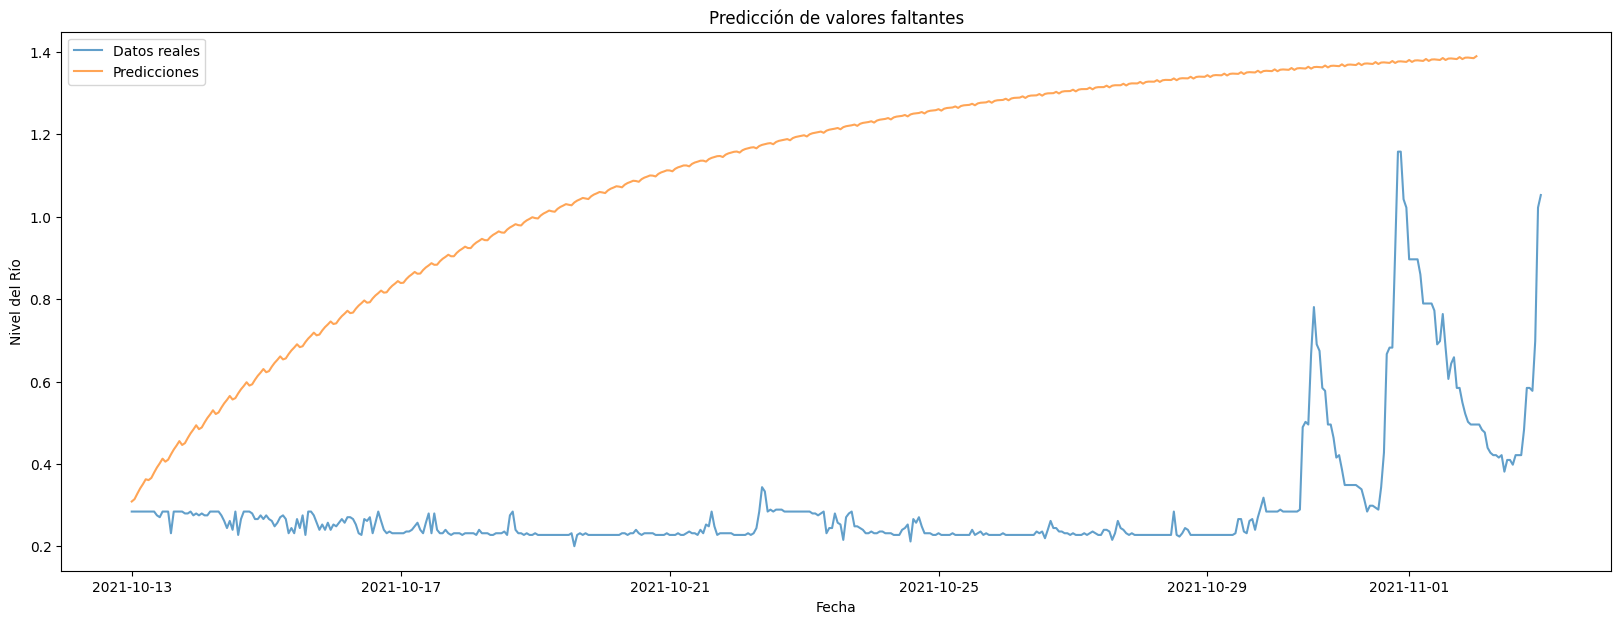

In [14]:
plt.figure(figsize=(20, 7))
plt.plot(urola_Data[start_date:end_date][variable], label='Datos reales', alpha=0.7)
plt.plot(df_pred[variable], label='Predicciones', alpha=0.7)
plt.legend()
plt.title('Predicción de valores faltantes')
plt.xlabel('Fecha')
plt.ylabel('Nivel del Río')
plt.show()
